In [13]:
import pandas as pd

# Read CSV file
df = pd.read_csv('../csv/simulink_buffer_output.csv')

# Display the first few rows
print(df.head())

   Index  BufferData
0      1           0
1      2           1
2      3           2
3      4           2
4      5           2


In [14]:
# 提取 BufferData 列
buffer_data = df['BufferData']

# 猜测的周期
period = 2**7  # 128

# 比较第一段（0 到 127）和第二段（128 到 255）
segment1 = buffer_data[0:period]
segment2 = buffer_data[period:2*period]

# 比较两个段的数据是否完全相同
# 需要重置索引再比较，因为原始索引不同
are_equal = segment1.reset_index(drop=True).equals(segment2.reset_index(drop=True))

if are_equal:
    print(f"前 {period} 个数据点与接下来的 {period} 个数据点完全相同。")
    print("数据很可能以 128 为周期重复。")
else:
    print(f"前 {period} 个数据点与接下来的 {period} 个数据点不相同。")
    
    # 找出第一个不匹配的位置
    comparison = segment1.reset_index(drop=True) == segment2.reset_index(drop=True)
    mismatch_indices = comparison[comparison == False].index
    
    if not mismatch_indices.empty:
        first_mismatch_index = mismatch_indices[0]
        print(f"第一个不匹配发生在段内索引: {first_mismatch_index}")
        print(f"第一个段中该位置的值: {segment1.iloc[first_mismatch_index]}")
        print(f"第二个段中该位置的值: {segment2.iloc[first_mismatch_index]}")

前 128 个数据点与接下来的 128 个数据点不相同。
第一个不匹配发生在段内索引: 0
第一个段中该位置的值: 0
第二个段中该位置的值: 2


检测到的第一个显著周期是: 127


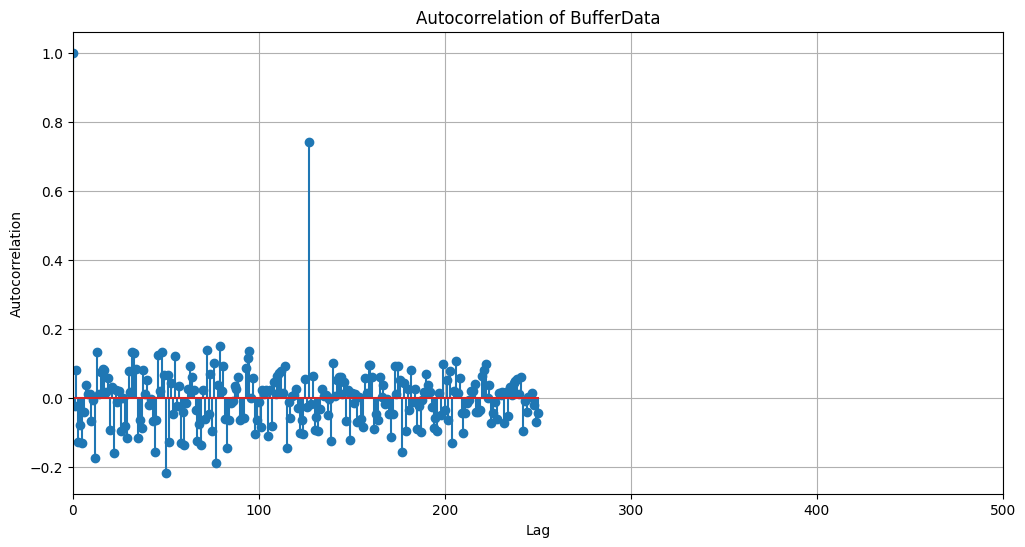

In [15]:
import numpy as np
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

# 提取 BufferData 列并转换为 numpy 数组
buffer_data = df['BufferData'].to_numpy()

# 计算自相关函数
# nlags 参数设置了我们计算的最大延迟量
autocorr = acf(buffer_data, nlags=len(buffer_data)//2)  # 计算一半长度的自相关

# 寻找自相关函数的峰值
# 我们忽略第一个峰值，因为它总是在延迟为 0 的位置
peaks = np.where(autocorr > 0.9)[0]  # 寻找强相关的延迟
if len(peaks) > 1:
    period = peaks[1] - peaks[0]
    print(f"检测到的数据周期大约是: {period}")
else:
    # 如果找不到明显的周期，可以尝试找第一个显著的峰值
    # 这里我们找第一个局部最大值
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(autocorr, height=0.5) # height 阈值可以调整
    if len(peaks) > 0:
        period = peaks[0]
        print(f"检测到的第一个显著周期是: {period}")
    else:
        period = -1
        print("未能检测到明显的周期。")

# 绘制自相关图
plt.figure(figsize=(12, 6))
plt.stem(autocorr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of BufferData")
plt.xlim(0, 500) # 限制 x 轴范围以便观察
plt.grid(True)
plt.show()


In [24]:
# 根据自相关分析，周期为 127
period = 127

# 提取第一个周期的数据作为重复序列
repeating_sequence = buffer_data[0:period]

print(f"检测到的重复序列 (长度 {len(repeating_sequence)}) 是:")
print(repeating_sequence)

# 验证：比较第一段和第二段序列
segment1 = buffer_data[0:period]
segment2 = buffer_data[period:2*period]

if np.array_equal(segment1, segment2):
    print("\n验证成功：数据确实以 127 为周期重复。")
else:
    print("\n验证失败：接下来的序列与找到的重复序列不完全匹配。")
    # 找出不匹配的位置
    diff_indices = np.where(segment1 != segment2)[0]
    if len(diff_indices) > 0:
        first_diff_index = diff_indices[0]
        print(f"第一个不匹配发生在序列内部索引: {first_diff_index}")
        print(f"第一个序列中的值: {segment1[first_diff_index]}")
        print(f"第二个序列中的值: {segment2[first_diff_index]}")


检测到的重复序列 (长度 127) 是:
[0 1 2 2 2 2 6 5 3 3 3 3 7 2 7 5 5 5 1 0 2 1 7 7 3 6 7 0 5 3 7 6 4 4 0 7 1
 4 1 7 3 6 7 4 6 5 7 6 4 0 3 4 5 6 3 5 4 2 2 2 6 1 2 7 5 5 1 0 6 2 1 7 3 6
 3 5 0 5 7 6 0 3 0 2 5 6 7 4 6 1 6 4 4 0 3 0 2 1 7 3 2 4 7 0 5 7 2 3 0 6 2
 5 2 0 4 3 5 4 6 5 7 2 3 4 5 6 7]

验证失败：接下来的序列与找到的重复序列不完全匹配。
第一个不匹配发生在序列内部索引: 0
第一个序列中的值: 0
第二个序列中的值: 4


In [17]:
# 忽略前5个数据点
offset = 5
buffer_data_offset = buffer_data[offset:]

# 周期仍然是 127
period = 127

# 确保我们有足够的数据进行比较
if len(buffer_data_offset) >= 2 * period:
    # 提取第一个周期的数据作为重复序列（从偏移后的数据中）
    repeating_sequence_offset = buffer_data_offset[0:period]

    print(f"从第 {offset+1} 个数据点开始，检测到的重复序列 (长度 {len(repeating_sequence_offset)}) 是:")
    print(repeating_sequence_offset)

    # 验证：比较第一段和第二段序列（从偏移后的数据中）
    segment1_offset = buffer_data_offset[0:period]
    segment2_offset = buffer_data_offset[period:2*period]

    if np.array_equal(segment1_offset, segment2_offset):
        print("\n验证成功：从第6个点开始，数据确实以 127 为周期重复。")
    else:
        print("\n验证失败：接下来的序列与找到的重复序列不完全匹配。")
        # 找出不匹配的位置
        diff_indices_offset = np.where(segment1_offset != segment2_offset)[0]
        if len(diff_indices_offset) > 0:
            first_diff_index_offset = diff_indices_offset[0]
            print(f"第一个不匹配发生在序列内部索引: {first_diff_index_offset}")
            print(f"第一个序列中的值: {segment1_offset[first_diff_index_offset]}")
            print(f"第二个序列中的值: {segment2_offset[first_diff_index_offset]}")
else:
    print(f"数据不足，无法在忽略前 {offset} 个点后比较两个完整的周期。")


从第 6 个数据点开始，检测到的重复序列 (长度 127) 是:
[2 6 5 3 3 3 3 7 2 7 5 5 5 1 0 2 1 7 7 3 6 7 0 5 3 7 6 4 4 0 7 1 4 1 7 3 6
 7 4 6 5 7 6 4 0 3 4 5 6 3 5 4 2 2 2 6 1 2 7 5 5 1 0 6 2 1 7 3 6 3 5 0 5 7
 6 0 3 0 2 5 6 7 4 6 1 6 4 4 0 3 0 2 1 7 3 2 4 7 0 5 7 2 3 0 6 2 5 2 0 4 3
 5 4 6 5 7 2 3 4 5 6 7 4 2 2 2 2]

验证成功：从第6个点开始，数据确实以 127 为周期重复。


In [20]:
repeating_sequence_offset_list = repeating_sequence_offset.tolist()
repeating_sequence_offset_list = repeating_sequence_offset_list[-6:] + repeating_sequence_offset_list[:-6]  # 将最后6个元素移到开头

In [22]:
import pyperclip

# 将 buffer_data 数组转换为列表格式并复制到剪贴板

# 将数组转换为列表格式的字符串
data_list_str = str(repeating_sequence_offset_list).replace(',', '')

# 复制到剪贴板
pyperclip.copy(data_list_str)

print(f"数据已复制到剪贴板，格式为列表:")
print(data_list_str[:100] + "..." if len(data_list_str) > 100 else data_list_str)

数据已复制到剪贴板，格式为列表:
[7 4 2 2 2 2 2 6 5 3 3 3 3 7 2 7 5 5 5 1 0 2 1 7 7 3 6 7 0 5 3 7 6 4 4 0 7 1 4 1 7 3 6 7 4 6 5 7 6 4...


In [23]:
repeating_sequence_offset_list.__len__()

127